In [1]:
# Imports
import os
import torch
import numpy as np
import re

# Training/Test Set Creation 
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import vidutils

# RNN Prediction and Result Visualization
from torch import nn
from sklearn.metrics import classification_report, confusion_matrix

# Results Plotting
import matplotlib.pyplot as plt

In [2]:
# Specify directories
frame_folder = "./data/frames"

# Create Training and Test Sets

## Define classes and preview

In [3]:
# Define label dictionary - 20 classes
syncs = [  "0-100 ms", "101-200 ms", "201-300 ms", "301-400 ms", "401-500 ms", 
         "501-600 ms", "601-700 ms", "701-800 ms", "801-900 ms", "901-1000 ms" ]
sync_dict = {}

count = 0
for sync_val in syncs:
    sync_dict[sync_val] = count
    count += 1

# preview dictionary
sync_dict

{'0-100 ms': 0,
 '101-200 ms': 1,
 '201-300 ms': 2,
 '301-400 ms': 3,
 '401-500 ms': 4,
 '501-600 ms': 5,
 '601-700 ms': 6,
 '701-800 ms': 7,
 '801-900 ms': 8,
 '901-1000 ms': 9}

## Load training data

In [4]:
### --------------------------------------------
# Choose datasets to use
real_data = True 
syn_data = False
### --------------------------------------------

X_paths = [] # paths of segment folders
y = [] # designated label

if real_data:
    # Specify directories
    frame_folder = "./data/frames"
    
    # Construct X = folder names, y = the label
    vf_list = []
    for f in os.listdir(frame_folder):
        if not f.startswith('.'):
            vf_list.append(f)
    
    for vf_folder in vf_list:
        # Create path to video
        vf_path = os.path.join(frame_folder, vf_folder)
        print("Current Video: "+ vf_folder)

        # Get individual segment folder
        segfolder_list = os.listdir(vf_path)

        # Check every segment folder
        for seg_folder in segfolder_list:

            if not seg_folder.startswith('.'):
                x_path = os.path.join(vf_path, seg_folder)
                X_paths.append(x_path + '/features.npz')

                # Extract class label from folder name
                label = int(seg_folder.split("_")[2])
                y.append(label)
        
if syn_data:
    # define synthetic data directory
    output_dir = './synthetic_data/output'
    output_list = os.listdir(output_dir)

    for output_folder in output_list:
        if output_folder.startswith('vid'):
            x_path = output_dir + '/' + output_folder
            X_paths.append(x_path)

            # Extract class label from folder name
            params = re.findall(r'\d+', output_folder)
            label = int( (int(params[3]) - 1) / 100)
            y.append(label)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


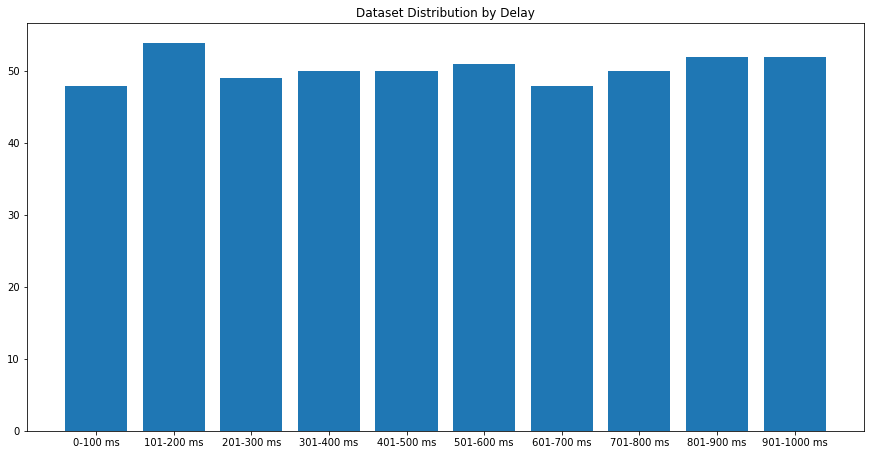

In [5]:
# Preview Data distribution
from collections import Counter
video_counter = Counter(y)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(video_counter.keys(), video_counter.values())
plt.xticks(range(0,10), syncs)
plt.title("Dataset Distribution by Delay")
plt.show()

In [6]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


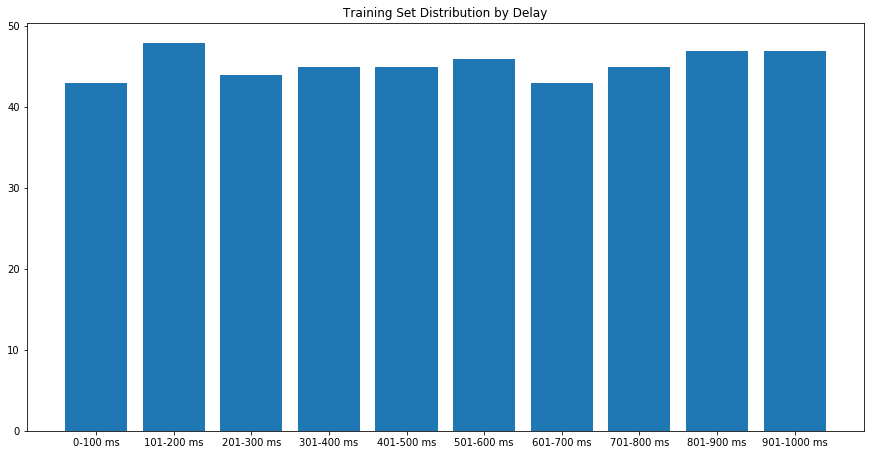

In [7]:
train_counter = Counter(train_ys)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(train_counter.keys(), train_counter.values())
plt.xticks(range(0,10), syncs)
plt.title("Training Set Distribution by Delay")
plt.show()

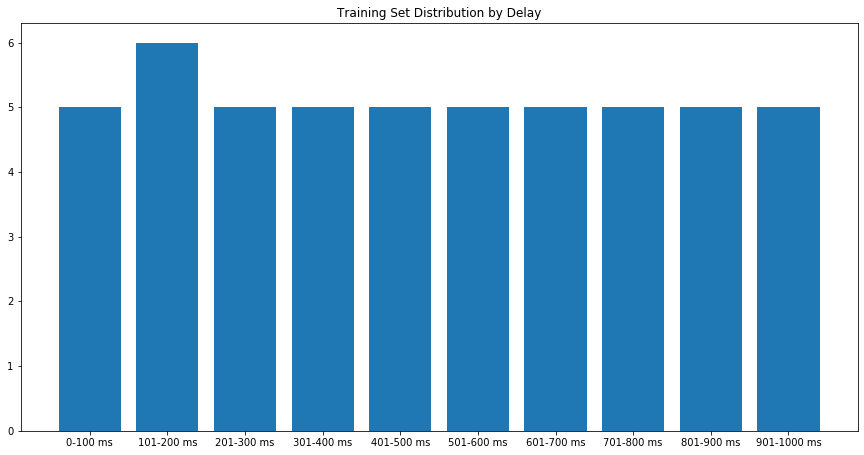

In [8]:
test_counter = Counter(test_ys)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(test_counter.keys(), test_counter.values())
plt.xticks(range(0,10), syncs)
plt.title("Training Set Distribution by Delay")
plt.show()

# Create Pytorch Dataset

In [9]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

In [10]:
# Define Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        num_frames = 20
        
        # extract features (different based on synthetic or real)
        if npz_path.startswith('./data/'):
            X_feat = data['feature_array']
        else:
            X_feat = vidutils.reshape_syn_features \
            (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

In [11]:
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0), 

class norm_with_saved(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [12]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor(),
])

In [13]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

453
51


# Model Definition 

In [14]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        batchsize = 1
        
        # Define Model Structure
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[frame_idx].view(1, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[frame_idx].view(1, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        output = self.fc1(output)
        
        return output

# Model Testing

In [15]:
# Setup model with parameters
model_params = {
    "num_classes": 10, # Use 10 for classifier, # 1 for regressor
    "rnn_num_layers": 1,
    "rnn_hidden_size": 200, # Best Classifier: 200
}
model = SyncRNN(model_params)

In [16]:
# Load the weights and set to GPU

# Models using Real Dataset 
weight_path = "./models/weights_norm_kpf_classifier.pt" # Trained classifier from Stage 2
#weight_path = "./models/Normalized KPF Models/weights_norm_kpf_classifier_200.pt" # Pre-trained Classifier
#weight_path = "./models/Normalized KPF Models/weights_norm_kpf_regressor_100.pt" # Pre-trained Regressor

# Models using Synthetic Dataset
#weight_path = "./models/Normalized KPF Models/weights_norm_kpf_classifier_syn.pt" # Pre-trained KPF Classifier

if torch.cuda.is_available():
    model.load_state_dict(torch.load(weight_path))
    device = torch.device("cuda:0")
else: 
    model.load_state_dict(torch.load(weight_path, map_location = lambda storage, location:storage))
    device = torch.device("cpu")

model = model.to(device)

## Training Set Results

In [17]:
ytrain_predictions = []
ytrain_actual = []
model.eval()
with torch.no_grad():
    count = 0
    correct_count = 0
    for train_X, train_y in training_dataset:
        output = model(train_X.to(device)).cpu()
        train_pred = output.argmax().item()
        ytrain_predictions.append(train_pred)
        ytrain_actual.append(train_y)
        #print("{}. Predicted: {} Actual: {}".format(count, train_pred, train_y))
        if train_pred == train_y:
            correct_count += 1
        count += 1
print("Total Score: {0}/453 = {1:.2f}%".format(correct_count, (correct_count/453)*100))

Total Score: 200/453 = 44.15%


In [18]:
# Classification Report
print(classification_report(ytrain_predictions, ytrain_actual))

              precision    recall  f1-score   support

           0       0.49      0.41      0.45        51
           1       0.42      0.36      0.38        56
           2       0.25      0.37      0.30        30
           3       0.47      0.44      0.45        48
           4       0.36      0.42      0.39        38
           5       0.54      0.61      0.57        41
           6       0.49      0.53      0.51        40
           7       0.40      0.37      0.38        49
           8       0.53      0.56      0.54        45
           9       0.47      0.40      0.43        55

    accuracy                           0.44       453
   macro avg       0.44      0.45      0.44       453
weighted avg       0.45      0.44      0.44       453



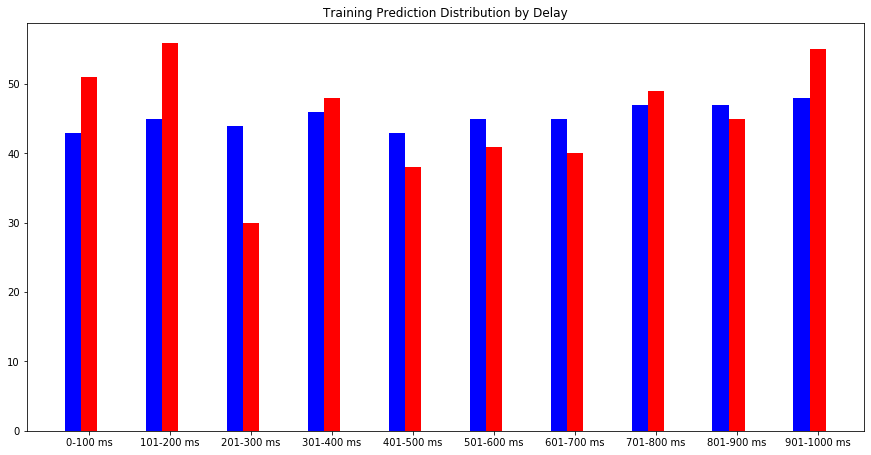

In [19]:
# Display Classifier Distribution
train_counter = Counter(train_ys)
train_counter_model = Counter(ytrain_predictions)
xbins = np.arange(0,10,1.0)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(xbins-0.2, train_counter.values(), width=0.2, color='b', align='center')
plt.bar(train_counter_model.keys(), train_counter_model.values(), width=0.2, color='r', align='center')

plt.xticks(range(0,10), syncs)
plt.title("Training Prediction Distribution by Delay")
plt.show()

## Test Set Results

In [20]:
ytest_predictions = []
ytest_actual = []
model.eval()
with torch.no_grad():
    count = 0
    correct_count = 0
    for test_X, test_y in testing_dataset:
        output = model(test_X.to(device)).cpu()
        test_pred = output.argmax().item()
        ytest_predictions.append(test_pred)
        ytest_actual.append(test_y)
        #print("{}. Predicted: {} Actual: {}".format(count, test_pred, test_y))
        if test_pred == test_y:
            correct_count += 1
        count += 1
print("Total Score: {0}/51 = {1:.2f}%".format(correct_count, (correct_count/51)*100))

Total Score: 9/51 = 17.65%


In [21]:
# Classification Report
print(classification_report(ytest_predictions, ytest_actual))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.33      0.29      0.31         7
           2       0.40      0.50      0.44         4
           3       0.20      0.25      0.22         4
           4       0.20      0.20      0.20         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         3
           7       0.60      0.38      0.46         8
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00         2

    accuracy                           0.18        51
   macro avg       0.17      0.16      0.16        51
weighted avg       0.21      0.18      0.19        51



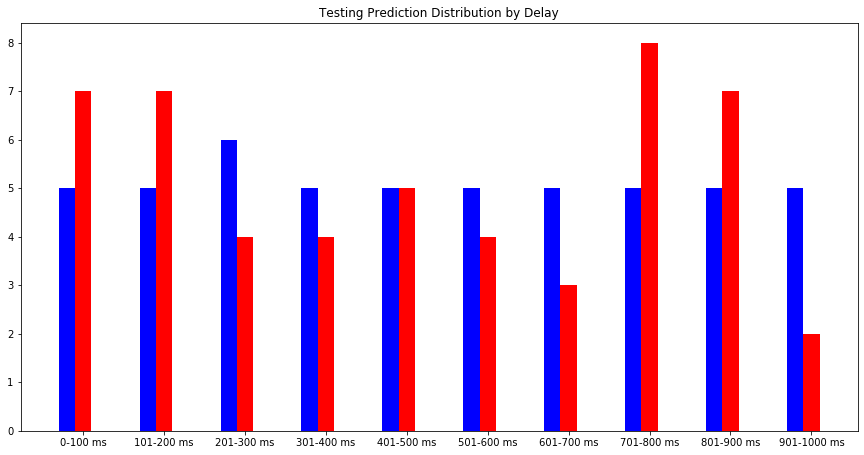

In [22]:
test_counter = Counter(test_ys)
test_counter_model = Counter(ytest_predictions)
xbins = np.arange(0,10,1.0)

fig, axes = plt.subplots(1,1, figsize=(15,7.5))
plt.bar(xbins-0.2, test_counter.values(), width=0.2, color='b', align='center')
plt.bar(test_counter_model.keys(), test_counter_model.values(), width=0.2, color='r', align='center')
plt.xticks(range(0,10), syncs)
plt.title("Testing Prediction Distribution by Delay")
plt.show()